In [230]:
# %%time

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold

!pip install catboost
from catboost import CatBoostClassifier as cb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [232]:
train = pd.read_csv('/content/Train_aBjfeNk.csv')
test = pd.read_csv('/content/Test_LqhgPWU.csv')

print('Train shape:{},{}'.format(train.shape[0], train.shape[1]))
print('Test shape:{},{}'.format(test.shape[0], test.shape[1]))

Train shape:8068,11
Test shape:2627,10


In [233]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [234]:
test.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

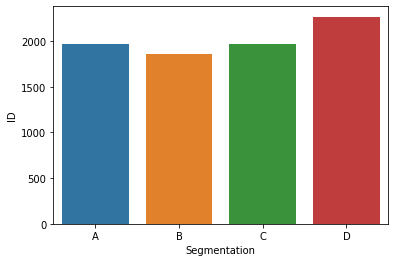

In [235]:
tmp = train.groupby(['Segmentation'])['ID'].count().reset_index()
sns.barplot(x='Segmentation', y='ID', data=tmp)

## Label Encoding

#### Use label encoding to encode categorical data. And custom encoding where hierarchy is to be preserved.

In [261]:
cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1', 'Segmentation']

le_gender = LabelEncoder()
le_married = LabelEncoder()
le_graduated = LabelEncoder()
le_profession = LabelEncoder()
le_segment = LabelEncoder()
le_source = LabelEncoder()

train['source'] = 'train'
test['source'] = 'test'

unified = pd.concat([train, test], axis=0)
unified.fillna('None', inplace=True)

unified['Gender'] = le_gender.fit_transform(unified['Gender'])
unified['Ever_Married'] = le_married.fit_transform(unified['Ever_Married'])
unified['Graduated'] = le_graduated.fit_transform(unified['Graduated'])
unified['Profession'] = le_profession.fit_transform(unified['Profession'])
unified['Segmentation'] = le_segment.fit_transform(unified['Segmentation'])
unified['source'] = le_source.fit_transform(unified['source'])

spending = {
      'Low' : 1
    , 'Average' : 2
    , 'High' : 3
}

var1 = {
      'Cat_1' : 1
    , 'Cat_2' : 2
    , 'Cat_3' : 3
    , 'Cat_4' : 4
    , 'Cat_5' : 5
    , 'Cat_6' : 6
    , 'Cat_7' : 7
    , 'None'  : 0

}

unified['Spending_Score'] = unified['Spending_Score'].map(spending)
unified['Var_1'] = unified['Var_1'].map(var1)
unified.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,source
0,462809,1,0,22.0,0,5,1.0,1,4.0,4,3,1
1,462643,0,2,38.0,2,2,2.0,2,3.0,4,0,1
2,466315,0,2,67.0,2,2,1.0,1,1.0,6,1,1
3,461735,1,2,67.0,2,7,0.0,3,2.0,6,1,1
4,462669,0,2,40.0,2,3,5.0,3,6.0,6,0,1


In [262]:
# Obtain encodings for missing values from each encoded column

def obtain_miss_val_encoding(encoding_fn):
  tmp = dict(zip(encoding_fn.classes_, 
                 encoding_fn.transform(encoding_fn.classes_)))
  return tmp


mapping_gender = obtain_miss_val_encoding(le_gender)
mapping_married = obtain_miss_val_encoding(le_married)
mapping_graduated = obtain_miss_val_encoding(le_graduated)
mapping_profession = obtain_miss_val_encoding(le_profession)
mapping_segment = obtain_miss_val_encoding(le_segment)
mapping_source = obtain_miss_val_encoding(le_source)

In [263]:
mapping_profession

{'Artist': 0,
 'Doctor': 1,
 'Engineer': 2,
 'Entertainment': 3,
 'Executive': 4,
 'Healthcare': 5,
 'Homemaker': 6,
 'Lawyer': 7,
 'Marketing': 8}

In [264]:
# Recode the missing values from encoded values in each column

unified.loc[unified['Ever_Married']==1, 'Ever_Married'] = 'None'
unified.loc[unified['Graduated']==1, 'Graduated'] = 'None'
unified.loc[unified['Profession']==9, 'Profession'] = 'None'
unified.loc[unified['Var_1']==0, 'Var_1'] = 'None'

unified.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,source
0,462809,1,0,22.0,0,5,1.0,1,4.0,4,3,1
1,462643,0,2,38.0,2,2,2.0,2,3.0,4,0,1
2,466315,0,2,67.0,2,2,1.0,1,1.0,6,1,1
3,461735,1,2,67.0,2,7,0.0,3,2.0,6,1,1
4,462669,0,2,40.0,2,3,5.0,3,6.0,6,0,1


In [265]:
unified.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
source             0
dtype: int64

## Impute missing values

In [266]:
unified = unified.replace('None', 99)
imputer = KNNImputer(missing_values=99, n_neighbors=5)

unified_imputed = unified.copy()
id = unified_imputed['ID'].reset_index(drop=True)
unified_imputed.drop(['ID'], axis=1, inplace=True)

cols = unified_imputed.columns
unified_imputed = pd.DataFrame(imputer.fit_transform(unified_imputed), columns=cols)
unified_imputed.reset_index(drop=True, inplace=True)
unified_imputed = pd.concat([id, unified_imputed], axis=1)

cols_with_miss_values = ['Ever_Married', 'Graduated', 'Profession',
                         'Work_Experience', 'Family_Size', 'Var_1']

for c in cols_with_miss_values:
  unified_imputed[c] = unified_imputed[c].apply(lambda x: round(x,0))

In [267]:
def recode_cat_var(df, encoding_fn, col):
  reverse_encoding_fn = {v:k for k, v in encoding_fn.items()}

  df[col] = df[col].map(reverse_encoding_fn)
  return df

rev_enc_map = {
        'Gender' : mapping_gender
      , 'Graduated' : mapping_graduated
      , 'Ever_Married' : mapping_married
      , 'Profession' : mapping_profession
      , 'Spending_Score' : spending
      , 'Var_1' : var1
      , 'Segmentation' : mapping_segment
      , 'source' : mapping_source
}

for k, v in rev_enc_map.items():
  unified_final = recode_cat_var(unified_imputed, v, k)

unified_final.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,source
0,462809,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,train
1,462643,Female,Yes,38.0,Yes,Engineer,2.0,Average,3.0,Cat_4,A,train
2,466315,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,train
3,461735,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,train
4,462669,Female,Yes,40.0,Yes,Entertainment,5.0,High,6.0,Cat_6,A,train


## Model building

In [243]:
train = unified_final[unified_final['source']=='train']
test = unified_final[unified_final['source']=='test']

train.drop(['source'], inplace=True, axis=1)
test.drop(['source', 'Segmentation'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [244]:
skf = StratifiedKFold(n_splits=5, random_state=55)

X = train.copy()
y = X[['Segmentation']]
X.drop(['Segmentation'], inplace=True, axis=1)
X.fillna('None', inplace=True)

cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1']

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [245]:
# # Catboost

# pred_X = pd.DataFrame()
# pred_y = pd.DataFrame()
# feature_importance = pd.DataFrame()

# for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
#   print('*'*20)
#   print('Iteration#: {}'.format(idx+1))

#   cat_params = {
#         'iterations' : 1000
#       , 'learning_rate' : 0.1
#       , 'depth' : 6
#       , 'eval_metric' : 'Accuracy'
#       , 'cat_features' : cat_features
#       , 'early_stopping_rounds' : 200
#   }
#   model = cb(**cat_params)

#   X_tr, y_tr, X_val, y_val = X.iloc[tr_idx], y.iloc[tr_idx], \
#                               X.iloc[val_idx], y.iloc[val_idx]

#   model.fit(X=X_tr, y=y_tr, eval_set=[(X_val, y_val)], verbose=50)

#   pred_X = pd.concat([pred_X, X_val], axis=0)
#   pred_y = pd.concat([pred_y, y_val], axis=0)

#   tmp_fi = pd.DataFrame()
#   tmp_fi['features'] = X_val.columns
#   tmp_fi['importance'] = cb.get_feature_importance(model)

#   feature_importance = pd.concat([feature_importance, tmp_fi], axis=0)

# feature_importance = feature_importance.groupby(['features'])['importance'].\
#                     mean().reset_index().\
#                     sort_values(by=['importance'], ascending=False)

# feature_importance

********************
Iteration#: 1
0:	learn: 0.5055779	test: 0.5092937	best: 0.5092937 (0)	total: 70.5ms	remaining: 1m 10s
50:	learn: 0.5590332	test: 0.5402726	best: 0.5439901 (6)	total: 2.12s	remaining: 39.5s
100:	learn: 0.5814998	test: 0.5539033	best: 0.5557621 (81)	total: 4.21s	remaining: 37.5s
150:	learn: 0.6143477	test: 0.5594796	best: 0.5600991 (126)	total: 6.46s	remaining: 36.3s
200:	learn: 0.6358847	test: 0.5551425	best: 0.5607187 (185)	total: 8.63s	remaining: 34.3s
250:	learn: 0.6560273	test: 0.5483271	best: 0.5607187 (185)	total: 10.8s	remaining: 32.4s
300:	learn: 0.6674930	test: 0.5477076	best: 0.5607187 (185)	total: 13s	remaining: 30.3s
350:	learn: 0.6867059	test: 0.5458488	best: 0.5607187 (185)	total: 15.2s	remaining: 28.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5607187113
bestIteration = 185

Shrink model to first 186 iterations.
********************
Iteration#: 2
0:	learn: 0.4772234	test: 0.4820322	best: 0.4820322 (0)	total: 47.6ms	remaining

,features,importance
6,Profession,23.075760
0,Age,16.235293
7,Spending_Score,15.669040
4,Graduated,9.074450
5,ID,8.289228
8,Var_1,7.915909
1,Ever_Married,6.281805
2,Family_Size,5.625800
9,Work_Experience,4.637766
3,Gender,3.194950


In [246]:
# debug_preds = pd.DataFrame()
# debug_preds = pd.concat([pred_X, pred_y], axis=1)
# debug_preds.columns.values[-1] = 'Actual'

# val_preds = pd.DataFrame(model.predict(pred_X))
# debug_preds = pd.concat([debug_preds, val_preds], axis=1)
# debug_preds.columns.values[-1] = 'Predicted'
# debug_preds.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Actual,Predicted
0,462809,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,D
1,462643,Female,Yes,38.0,Yes,Engineer,2.0,Average,3.0,Cat_4,A,A
2,466315,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,B
3,461735,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,C
4,462669,Female,Yes,40.0,Yes,Entertainment,5.0,High,6.0,Cat_6,A,B


In [247]:
# accuracy_score(debug_preds['Actual'], debug_preds['Predicted'])
# # 0.5767228557263262

0.5767228557263262

In [248]:
# test1 = test.copy()
# test1.fillna('None', inplace=True)
# preds = pd.DataFrame(model.predict(test1), columns=['Segmentation'])

# ids = test1['ID'].reset_index(drop=True)
# preds.reset_index(drop=True, inplace=True)
# preds = pd.concat([ids, preds], axis=1)
# preds.to_csv('Imputed_catboost_08012020.csv', index=False)

# preds.head()

In [281]:
# One-Hot Encoding Train and Test

encode_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1']
unified_final_dummies = pd.DataFrame()

unified_final_dummies = pd.get_dummies(unified_final[encode_cols],
                                       prefix=encode_cols)

miss_cols = ['ID', 'Age', 'Work_Experience', 'Family_Size',
             'Segmentation', 'source']

unified_final_dummies.reset_index(drop=True, inplace=True)
unified_final.reset_index(drop=True, inplace=True)

unified_final_dummies = pd.concat([unified_final[miss_cols],
                                   unified_final_dummies], axis=1)

unified_final_dummies.head()

,ID,Age,Work_Experience,Family_Size,Segmentation,source,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22.0,1.0,4.0,D,train,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,462643,38.0,2.0,3.0,A,train,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,466315,67.0,1.0,1.0,B,train,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,461735,67.0,0.0,2.0,B,train,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,462669,40.0,5.0,6.0,A,train,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [282]:
train = unified_final_dummies[unified_final_dummies['source']=='train']
test = unified_final_dummies[unified_final_dummies['source']=='test']

train.drop(['source'], inplace=True, axis=1)
test.drop(['source', 'Segmentation'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [283]:
skf = StratifiedKFold(n_splits=5, random_state=55)

X = train.copy()
y = X[['Segmentation']]
X.drop(['Segmentation'], inplace=True, axis=1)
X.fillna('None', inplace=True)

cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1']

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [284]:
X.head()

,ID,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22.0,1.0,4.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,462643,38.0,2.0,3.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,466315,67.0,1.0,1.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,461735,67.0,0.0,2.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,462669,40.0,5.0,6.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


********************
Iteration#: 1
[0]	validation_0-merror:0.492565
Will train until validation_0-merror hasn't improved in 200 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[50]	validation_0-merror:0.45601
[100]	validation_0-merror:0.44176
[150]	validation_0-merror:0.445477
[200]	validation_0-merror:0.444858
[250]	validation_0-merror:0.449195
[300]	validation_0-merror:0.449195
Stopping. Best iteration:
[103]	validation_0-merror:0.44052

********************
Iteration#: 2
[0]	validation_0-merror:0.511772
Will train until validation_0-merror hasn't improved in 200 rounds.
[50]	validation_0-merror:0.47088
[100]	validation_0-merror:0.454771
[150]	validation_0-merror:0.459108
[200]	validation_0-merror:0.456629
[250]	validation_0-merror:0.457869
[300]	validation_0-merror:0.457249
[350]	validation_0-merror:0.464064
[400]	validation_0-merror:0.467162
[450]	validation_0-merror:0.469641
Stopping. Best iteration:
[277]	validation_0-merror:0.451673

********************
Iteration#: 3
[0]	validation_0-merror:0.513631
Will train until validation_0-merror hasn't improved in 200 rounds.
[50]	validation_0-merror:0.469641
[100]	validation_0-merror:0.462825
[150]	validation

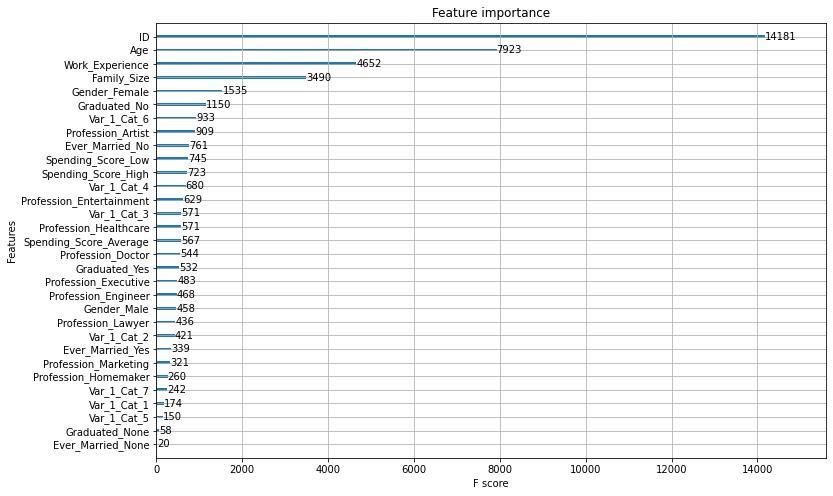

In [292]:
# XGBoost

pred_X = pd.DataFrame()
pred_y = pd.DataFrame()

for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
  print('*'*20)
  print('Iteration#: {}'.format(idx+1))

  xgb_params = {
        'booster' : 'gbtree'
      , 'learning_rate' : 0.1
      , 'metric' : 'merror'
      , 'max_depth' : 6
      , 'colsample_bytree' : 0.7
      , 'objective' : 'multi:softmax'
      , 'seed' : 55
      , 'num_class' : 4
      , 'n_estimators' : 1000
  }

  X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx], \
                              y.iloc[tr_idx], y.iloc[val_idx]

  clf = XGBClassifier(**xgb_params)
  model = clf.fit(X=X_tr, y=y_tr, eval_set=[(X_val, y_val)], \
                  early_stopping_rounds=200, verbose=50)
  
  pred_X = pd.concat([pred_X, X_val], axis=0)
  pred_y = pd.concat([pred_y, y_val], axis=0)

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)

In [293]:
debug_preds = pd.DataFrame()
debug_preds = pd.concat([pred_X, pred_y], axis=1)
debug_preds.columns.values[-1] = 'Actual'

val_preds = pd.DataFrame(model.predict(pred_X))
debug_preds = pd.concat([debug_preds, val_preds], axis=1)
debug_preds.columns.values[-1] = 'Predicted'
debug_preds.head()

,ID,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Actual,Predicted
0,462809,22.0,1.0,4.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,D,D
1,462643,38.0,2.0,3.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,A,D
2,466315,67.0,1.0,1.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,B,B
3,461735,67.0,0.0,2.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,B,C
4,462669,40.0,5.0,6.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,A,A


In [294]:
accuracy_score(debug_preds['Actual'], debug_preds['Predicted'])
# 0.5767228557263262

0.6854238968765494

In [295]:
test1 = test.copy()
test1.fillna('None', inplace=True)
preds = pd.DataFrame(model.predict(test1), columns=['Segmentation'])

ids = test1['ID'].reset_index(drop=True)
preds.reset_index(drop=True, inplace=True)
preds = pd.concat([ids, preds], axis=1)
preds.to_csv('xgboost_08012020.csv', index=False)

preds.head()

,ID,Segmentation
0,458989,B
1,458994,C
2,458996,D
3,459000,C
4,459001,D
